In [ ]:
'''
PPCA 2.0 Data filter / Residential & Non-residential Buildings Classification based on Attribute values

The script processes and filter spatial data from OSM and GHS sources for further analysis. It performs four main tasks: (1) It reads and filters 
Global Human Settlement (GHS) data by rounding values and removing meshes with zero population (2) It filters OpenStreetMap (OSM) streets data to 
separate pedestrian and non-pedestrian streets (3) It filters OSM land use data to identify non-populated areas (4) It classifies building types 
from OSM building data into three categories (# 0 : NA ; 1 : residential or mixed-use ; 2 : non-residential) based on their attributes and spatial 
relationships with non-populated land use areas, adjusting the classification with additional criteria, and finally saves the updated classification
data in a column named 'type'.

Requirements:
- A specific working environment (see github page of the project)
- Geopackage file from PPCA 1.0

Guide to run the script:
- Fill 0.2 box

Author : Perez, Joan 
'''

In [1]:
# 0.1 : libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [58]:
# 0.2 : Box to fil with informations

# Name of the case study
Name = 'Wien'

# Recall the ghs date (extracted in previous step)
ghs_date = 2020

# Define projected CRS
projected_crs = 'EPSG:31287'

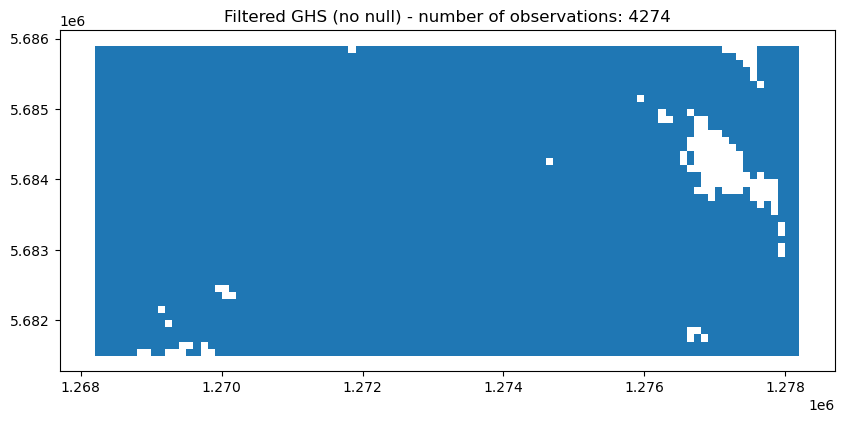

In [59]:
# 1. FILTER GHS DATA
gpkg = f'PPCA1_{Name}.gpkg'
gpkg2 = f'PPCA2_{Name}.gpkg'
ghs_vector = gpd.read_file(gpkg, layer = f'ghs_{ghs_date}_vector')

# Round the values in the "values" column
ghs_vector['VALUE'] = ghs_vector['VALUE'].round()

# Filter out rows with a value of 0
ghs_vector = ghs_vector[ghs_vector['VALUE'] != 0]

# Save & plot
ghs_vector.to_file(gpkg2, layer = f'ghs_populated_{ghs_date}_vector', driver="GPKG")
num_observations = len(ghs_vector)
fig, ax = plt.subplots(figsize=(10, 10))
ghs_vector.plot(ax=ax)
ax.set_title(f'Filtered GHS (no null) - number of observations: {num_observations}')
plt.show()

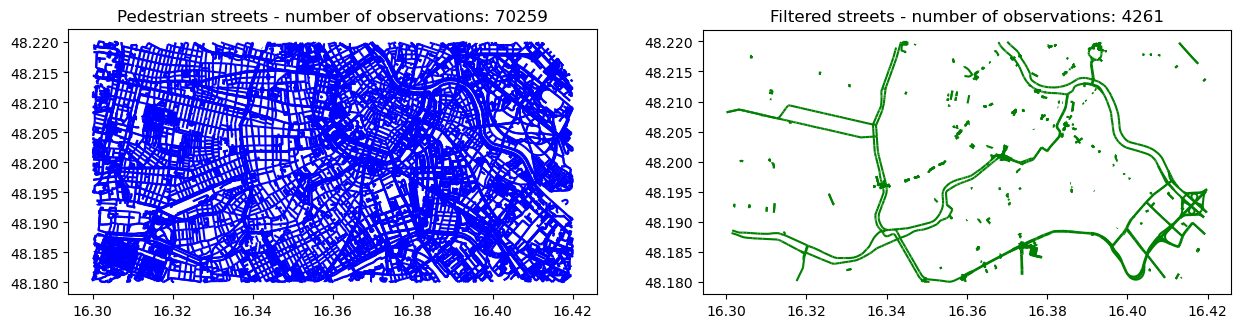

In [60]:
# 2. FILTER OSM STREETS DATA
linestrings_gdf = gpd.read_file(gpkg, layer = 'osm_all_streets')

# Remove non-pedestrian streets
removed_streets = linestrings_gdf[
    linestrings_gdf['highway'].str.contains('motorway|motorway_link|primary|primary_link|trunk|trunk_link', na=False) |
    (linestrings_gdf['tunnel'] == 'yes')
]

# Keep pedestrian streets
pedestrian_streets = linestrings_gdf[
    ~linestrings_gdf['highway'].str.contains('motorway|motorway_link|primary|primary_link|trunk|trunk_link', na=False) &
    (linestrings_gdf['tunnel'] != 'yes')
]

# Plot pedestrian_streets & non-pedestrian streets
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
num_observations = len(pedestrian_streets)
pedestrian_streets.plot(ax=axes[0], color='blue')
axes[0].set_title(f'Pedestrian streets - number of observations: {num_observations}')
num_observations = len(removed_streets)
removed_streets.plot(ax=axes[1], color='green')
axes[1].set_title(f'Filtered streets - number of observations: {num_observations}')
plt.show()

# Save
pedestrian_streets.to_file(gpkg2, layer='pedestrian_streets', driver="GPKG")
removed_streets.to_file(gpkg2, layer='non_pedestrian_streets', driver="GPKG")

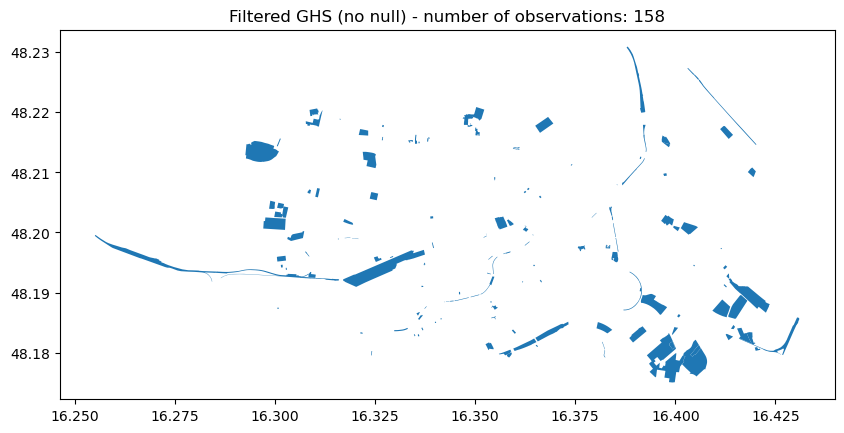

In [61]:
# 3. FILTER OSM LANDUSE DATA
all_areas = gpd.read_file(gpkg, layer = 'osm_all_area_categories')

# Remove non-populated landuse areas
non_populated_areas = all_areas[
    all_areas['landuse'].str.contains(
        'construction|cemetery|education|healthcare|industrial|military|railway|religious|port|winter_sports', 
        na=False
    )
]

# Save & plot
non_populated_areas.to_file(gpkg2, layer='osm_non_populated_areas', driver="GPKG")
num_observations = len(non_populated_areas)
fig, ax = plt.subplots(figsize=(10, 10))
non_populated_areas.plot(ax=ax)
ax.set_title(f'Filtered GHS (no null) - number of observations: {num_observations}')
plt.show()

Percentage and count of building types using attribute values, specialized columns & landuse
1 : Residential or mixed-use: 61.44% (17566 buildings)
0 : NA: 28.74% (8216 buildings)
2 : Non-residential: 9.83% (2810 buildings)


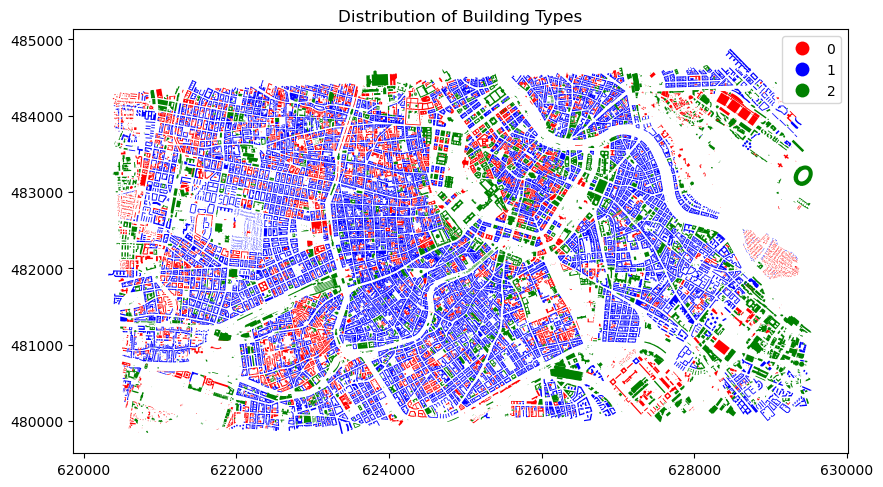

In [62]:
# 4. CLASIFICATION OF BUILDING TYPES
# Read all buildings from PPCA 1.0
all_building = gpd.read_file(gpkg, layer = 'osm_all_buildings')

# Calculate the footprint of each building
all_building = all_building.to_crs(projected_crs)
all_building['area'] = all_building.geometry.area

# Filter out buildings with a surface footprint less than 15 m²
building_filtered = all_building[all_building['area'] >= 15]

# Filter out buildings with no walls (if the wall column exists)
if 'wall' in building_filtered.columns:
    building_filtered = building_filtered[building_filtered['wall'] != 'no']

# Define a function to determine the type based on the 'building' column (0 : NA ; 1 : residential or mixed-use ; 2 : non-residential)
# Attribute values : https://wiki.openstreetmap.org/wiki/Key:building
def assign_type(building_type):
    if building_type == 'yes':
        return 0
    elif building_type in ['apartments', 'barracks', 'house', 'residential', 'bungalow', 'cabin', 'detached', 'dormitory', 'farm', 'static_caravan',
                          'semidetached_house', 'stilt_house']:
        return 1
    else:
        return 2

# Add a new column 'type' and apply the conditions
building_filtered = building_filtered.copy()
building_filtered.loc[:, 'type'] = building_filtered['building'].apply(assign_type)

# Spatial join with non-residential landuse areas
non_populated_areas = non_populated_areas.to_crs(projected_crs)
joined_data = gpd.sjoin(building_filtered, non_populated_areas, how="left", predicate="intersects")

# Buildings with NA in non-residential landuse areas are given the value 2 (non residential)
joined_data.loc[(joined_data['type'] == 0) & joined_data['landuse'].notnull(), 'type'] = 2

# Update 'type' to 2 if 'type' is 0 (NA) and at least one non-null value exists in the following columns : 'tourism', 'parking', 'shop' or 'office'
condition = (joined_data['type'] == 0) & \
            (joined_data['tourism'].notnull() | \
             joined_data['parking'].notnull() | \
             joined_data['shop'].notnull() | \
             joined_data['office'].notnull())
joined_data.loc[condition, 'type'] = 2

# Print the percentage and count of each building type
feature_counts = joined_data['type'].value_counts()
type_counts = joined_data['type'].value_counts(normalize=True) * 100
print("Percentage and count of building types using attribute values, specialized columns & landuse")
for type_code, percentage in type_counts.items():
    feature_count = feature_counts[type_code]
    if type_code == 0:
        print(f"0 : NA: {percentage:.2f}% ({feature_count} buildings)")
    elif type_code == 1:
        print(f"1 : Residential or mixed-use: {percentage:.2f}% ({feature_count} buildings)")
    else:
        print(f"2 : Non-residential: {percentage:.2f}% ({feature_count} buildings)")

columns_to_drop = ['index_right', 'element_type_right', 'osmid_right', 'landuse']
joined_data = joined_data.drop(columns=columns_to_drop)

# Plot with custom colors
colors = ['red', 'blue', 'green']
fig, ax = plt.subplots(figsize=(10, 10))
joined_data.plot(column='type', categorical=True, legend=True, ax=ax, cmap=ListedColormap(colors))
plt.title('Distribution of Building Types')
plt.show()

joined_data.to_file(gpkg2, layer='osm_buildings_use_with_NA', driver="GPKG")